# Movie Recommendation System

We build a basic content-based recommendation system and collaborative filtering based on user rankings using the MovieLens dataset.

**Movielens dataset:** http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

The dataset contains 100,000 ratings on 9,000 movies by 600 users.  

**-** movies.csv file shows every movie with its id, title, and genre.

**-** To describe users' relation with movies we used the ratings.csv file which defines every user with 'userId' and shows their 'rating' based on 'movieId'.

First, we will use this dataset to recommend movies with a content-based system then we will train our model and recommend movies with model-based Collaborative Filtering with the KNN algorithm.



We also used another small dataset to create a GUI for content based sytem.

**IMDB Movie Dataset:** https://data.world/login?next=%2Fhiman%2Fimdb-movie-dataset%2Fworkspace%2Ffile%3Ffilename%3Dmovie_data.csv

# Libraries

In [1]:
import import_ipynb
import numpy as np
import pandas as pd
import sklearn
from scipy import sparse
import matplotlib.pyplot as plt
from surprise import SVD
from surprise import accuracy
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process
from surprise import Reader, Dataset
from sklearn.metrics.pairwise import cosine_similarity
from surprise.accuracy import rmse, mae
from surprise.model_selection import cross_validate
from collections import defaultdict

# Import data

In [2]:
movies = pd.read_csv('movies.csv')

Return 5 rows of movies data

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings = pd.read_csv('ratings.csv')

Return 5 rows of ratings data

In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


We can see that movie data contains **9742** entries and 3 columns 

# Explore Data

In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Ratings data contains **100,836** entries and 4 columns 

In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


We will merge this two data based on ids but before merging we will look number of unique ids

In [8]:
len(movies.movieId.unique())

9742

In [9]:
len(ratings.movieId.unique())

9724

We were expecting same number of movie ids on both data file but they are different

In [10]:
len(movies.title.unique())

9737

And number of movie titles are more then number of unique movie ids

If we check duplicates on title attribute, we can see that some of the movies are defined with different ids although they have same title. Their genre looks different

In [11]:
movies[movies.title.duplicated(keep=False)].sort_values(by='title')

,movieId,title,genres
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
650,838,Emma (1996),Comedy|Drama|Romance
5601,26958,Emma (1996),Romance
5854,32600,Eros (2004),Drama
9135,147002,Eros (2004),Drama|Romance
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
6932,64997,War of the Worlds (2005),Action|Sci-Fi


Before we fix this problem, we will first merge two data based on movieId attribute

In [12]:
merged_data = pd.merge(ratings, movies, on='movieId')

Now we can see user's movie ratings

In [13]:
merged_data

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
100831,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller


Print one of the movie which has more than one id

In [14]:
print(merged_data[merged_data.title=='Emma (1996)'])

       userId  movieId  rating   timestamp        title                genres
33502       6      838     4.0   845555514  Emma (1996)  Comedy|Drama|Romance
33503      12      838     5.0  1247264096  Emma (1996)  Comedy|Drama|Romance
33504      33      838     5.0   939716327  Emma (1996)  Comedy|Drama|Romance
33505      57      838     3.0   965797105  Emma (1996)  Comedy|Drama|Romance
33506      68      838     3.5  1158535598  Emma (1996)  Comedy|Drama|Romance
33507      84      838     5.0   857653794  Emma (1996)  Comedy|Drama|Romance
33508     100      838     4.5  1100184279  Emma (1996)  Comedy|Drama|Romance
33509     104      838     4.0  1049291806  Emma (1996)  Comedy|Drama|Romance
33510     108      838     5.0  1042840302  Emma (1996)  Comedy|Drama|Romance
33511     113      838     4.0   980051757  Emma (1996)  Comedy|Drama|Romance
33512     132      838     2.0  1157923556  Emma (1996)  Comedy|Drama|Romance
33513     156      838     3.0   939843105  Emma (1996)  Comedy|

At the last column same movie has different id. We see that reason of the duplicate id is genres. But on collaborative filtering we will use movie titles to specify movies so movieId does not looks like a problem for our situation

When we count the number of votes for each movie we see that they are not equal. Because we have sparse data. If there would not be any empty rating value (which means every user watched every movie), there would not any need for a recommendation system

In [15]:
print(merged_data.groupby('title')['rating'].count().sort_values(ascending=False))

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
                                            ... 
King Solomon's Mines (1950)                    1
King Solomon's Mines (1937)                    1
King Ralph (1991)                              1
King Kong Lives (1986)                         1
À nous la liberté (Freedom for Us) (1931)      1
Name: rating, Length: 9719, dtype: int64


We will not use timestamp attribute so we will drop this column

In [16]:
merged_data.drop(columns=['timestamp'], inplace=True)

In [17]:
movie_mean = pd.DataFrame(merged_data.groupby('title').mean())
movie_mean['counts'] = merged_data.groupby('title')['rating'].count()
print(movie_mean.sort_values(by=['rating'], ascending=False))

                                         userId   movieId  rating  counts
title                                                                    
Gena the Crocodile (1969)                 105.0  175293.0     5.0       1
True Stories (1986)                       260.0    7815.0     5.0       1
Cosmic Scrat-tastrophe (2015)              89.0  146684.0     5.0       1
Love and Pigeons (1985)                   105.0  130978.0     5.0       1
Red Sorghum (Hong gao liang) (1987)       603.0    2972.0     5.0       1
...                                         ...       ...     ...     ...
Don't Look Now (1973)                     594.0    5105.0     0.5       1
Journey 2: The Mysterious Island (2012)   567.0   92681.0     0.5       1
Joe Dirt 2: Beautiful Loser (2015)        298.0  138798.0     0.5       1
Jesus Christ Vampire Hunter (2001)        599.0   27595.0     0.5       1
Fullmetal Alchemist 2018 (2017)           184.0  184641.0     0.5       1

[9719 rows x 4 columns]


As we see above, movies which has only one vote can have high rating value. That shows us rating value does not mean this movie is popular by users

We can plot a histogram to see how rating value distribute

Text(0, 0.5, 'Number of movies')

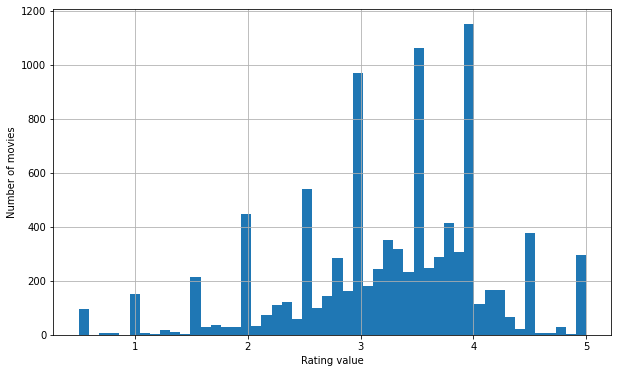

In [18]:
plt.figure(figsize=[10,6])
movie_mean.rating.hist(bins=50)
plt.xlabel('Rating value')
plt.ylabel('Number of movies')

# Data Preprocessing

In [19]:
df_movies_cnt = pd.DataFrame(ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,215
2,110
3,52
4,7
5,49


As we mentioned before, not every movie has the same number of votes. This can mislead us while training our model. To prevent this we described the threshold value as 10 which means we will not include movies that have fewer votes than 10.

In [20]:
movie_id_count = pd.DataFrame(merged_data.groupby('movieId').size(), columns=['count'])
popular_movies = list(set(movie_id_count.query('count >= 10').index))

We collected all movie indexes, which has more than 10 votes, in a list called as popular_movies.
We checked if a movie in merged_data is in populer_movies and stored them in drop_movies.

In [21]:
drop_movies = merged_data[merged_data.movieId.isin(popular_movies)]
print('Original data: ', merged_data.shape)
print('Data after dropping unpopular movies: ', drop_movies.shape)

Original data:  (100836, 5)
Data after dropping unpopular movies:  (81116, 5)


Now we have a movie dataset which includes movies with more than 10 votes.
We will apply the same process for user who voted less than or equal to 10.

In [22]:
df_users_cnt = pd.DataFrame(drop_movies.groupby('userId').size(), columns=['count'])
active_users = list(set(df_users_cnt.query('count >= 10').index))
drop_users = drop_movies[drop_movies.userId.isin(active_users)]
print('Original data: ', merged_data.shape)
print('Data after dropping both unpopular movies and inactive users: ', drop_users.shape)

Original data:  (100836, 5)
Data after dropping both unpopular movies and inactive users:  (81109, 5)


Now our dataset can present the real data with less value and more accuracy.

Text(0, 0.5, 'Number of movies')

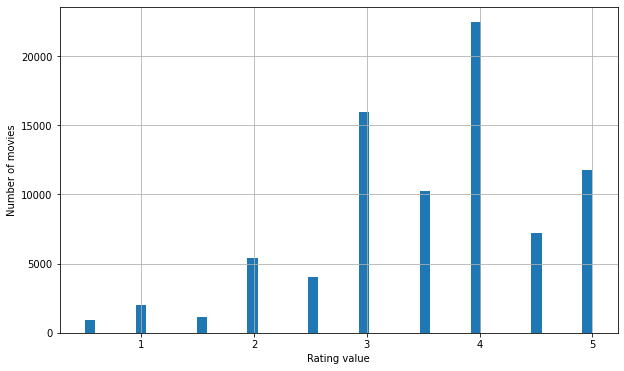

In [23]:
plt.figure(figsize=[10,6])
drop_users.rating.hist(bins=50)
plt.xlabel('Rating value')
plt.ylabel('Number of movies')

Group movies by their title and count how much they voted.

In [24]:
drop_users.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: rating, dtype: int64

We will create a dataframe to store rating averages of movies and their vote count.

In [25]:
ratings_dataframe = pd.DataFrame(drop_users.groupby('title')['rating'].mean())
ratings_dataframe.rename(columns={'rating': 'avg_rating'}, inplace=True)
ratings_dataframe['votes'] = pd.DataFrame(drop_users.groupby('title')['rating'].count())
ratings_dataframe

,avg_rating,votes
title,,
"'burbs, The (1989)",3.176471,17
(500) Days of Summer (2009),3.666667,42
10 Cloverfield Lane (2016),3.678571,14
10 Things I Hate About You (1999),3.527778,54
"10,000 BC (2008)",2.705882,17
...,...,...
Zoolander (2001),3.509259,54
Zootopia (2016),3.890625,32
eXistenZ (1999),3.863636,22


As seen below, the most voted movie is 'Forrest Gump' with a rating of 4.16

In [26]:
ratings_dataframe.sort_values(by='votes', ascending=False).head()

,avg_rating,votes
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278


# Content Based

Create a spreadsheet-style pivot table

In [27]:
user_movie_rates = drop_users.pivot_table(index='userId', columns='title', values='rating')

In [28]:
user_movie_rates

title,"'burbs, The (1989)",(500) Days of Summer (2009),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),12 Years a Slave (2013),127 Hours (2010),...,Zack and Miri Make a Porno (2008),Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4.5,3.5,NaN


Select a movie (Zombieland (2009)) to calculate similarity with other movies and improve our model on it.

In [29]:
zombieland_rates = user_movie_rates['Zombieland (2009)']

In [30]:
zombieland_rates

userId
1      NaN
2      3.0
3      NaN
4      NaN
5      NaN
      ... 
606    NaN
607    NaN
608    NaN
609    NaN
610    3.5
Name: Zombieland (2009), Length: 609, dtype: float64

The Zombieland movie is voted by user2 and user610. We will create a profile for each movie based on how the entirety of users rated it.

We will use corrwith() to get correlation between 2 DataFrame objects.

In [31]:
zombieland_corr = user_movie_rates.corrwith(zombieland_rates)

/Users/cerencicek/Library/Python/3.8/lib/python/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/cerencicek/Library/Python/3.8/lib/python/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [32]:
zombieland_corr

title
'burbs, The (1989)                   0.647150
(500) Days of Summer (2009)         -0.049175
10 Cloverfield Lane (2016)           0.612372
10 Things I Hate About You (1999)    0.276340
10,000 BC (2008)                     0.226871
                                       ...   
Zoolander (2001)                    -0.187575
Zootopia (2016)                      0.119645
eXistenZ (1999)                      0.996116
xXx (2002)                           0.248305
¡Three Amigos! (1986)                0.580292
Length: 2269, dtype: float64

We will add correlation values to our dataframe as a new column.

In [33]:
zombieland_corr = pd.DataFrame(zombieland_corr, columns=['Correlation'])

In [34]:
zombieland_corr

,Correlation
title,
"'burbs, The (1989)",0.647150
(500) Days of Summer (2009),-0.049175
10 Cloverfield Lane (2016),0.612372
10 Things I Hate About You (1999),0.276340
"10,000 BC (2008)",0.226871
...,...
Zoolander (2001),-0.187575
Zootopia (2016),0.119645
eXistenZ (1999),0.996116


Drop NaN values

In [35]:
zombieland_corr.dropna(inplace=True)
zombieland_corr

,Correlation
title,
"'burbs, The (1989)",0.647150
(500) Days of Summer (2009),-0.049175
10 Cloverfield Lane (2016),0.612372
10 Things I Hate About You (1999),0.276340
"10,000 BC (2008)",0.226871
...,...
Zoolander (2001),-0.187575
Zootopia (2016),0.119645
eXistenZ (1999),0.996116


When we sort the correlation column in descending order, we see that some movies have a 1.0 correlation value and some have -1.0. This shows us the movies which have 1.0 correlation values are very similar to 'Zombieland' movie.

In [36]:
zombieland_corr.sort_values('Correlation', ascending=False)

,Correlation
title,
Elizabeth (1998),1.0
"Gods Must Be Crazy, The (1980)",1.0
"Hate (Haine, La) (1995)",1.0
Dune (1984),1.0
Friday (1995),1.0
...,...
"English Patient, The (1996)",-1.0
Ben-Hur (1959),-1.0
M (1931),-1.0


We also added the number of votes for those movies

In [37]:
zombieland_corr_count = zombieland_corr.join(ratings_dataframe['votes'])
zombieland_corr_count

,Correlation,votes
title,,
"'burbs, The (1989)",0.647150,17
(500) Days of Summer (2009),-0.049175,42
10 Cloverfield Lane (2016),0.612372,14
10 Things I Hate About You (1999),0.276340,54
"10,000 BC (2008)",0.226871,17
...,...,...
Zoolander (2001),-0.187575,54
Zootopia (2016),0.119645,32
eXistenZ (1999),0.996116,22


In [38]:
zombieland_corr_count.sort_values('Correlation', ascending=False)

,Correlation,votes
title,,
Elizabeth (1998),1.0,23
"Gods Must Be Crazy, The (1980)",1.0,28
"Hate (Haine, La) (1995)",1.0,10
Dune (1984),1.0,37
Friday (1995),1.0,20
...,...,...
"English Patient, The (1996)",-1.0,45
Ben-Hur (1959),-1.0,34
M (1931),-1.0,15


In [39]:
zombieland_corr_count.sort_values('votes', ascending=False)

,Correlation,votes
title,,
Forrest Gump (1994),0.076196,329
"Shawshank Redemption, The (1994)",0.228896,317
Pulp Fiction (1994),-0.120496,307
"Silence of the Lambs, The (1991)",0.252309,279
"Matrix, The (1999)",0.041859,278
...,...,...
Drunken Master (Jui kuen) (1978),1.000000,10
Resident Evil: Extinction (2007),0.162602,10
Mona Lisa Smile (2003),-0.944911,10


In [40]:
zombieland_corr_count_corr1 = zombieland_corr_count[zombieland_corr_count['Correlation']==1]
zombieland_corr_count_corr1

,Correlation,votes
title,,
2010: The Year We Make Contact (1984),1.0,17
8MM (1999),1.0,18
Back to School (1986),1.0,16
"Basketball Diaries, The (1995)",1.0,15
Bringing Up Baby (1938),1.0,18
Broadcast News (1987),1.0,28
"Brothers McMullen, The (1995)",1.0,12
Conspiracy Theory (1997),1.0,43
Days of Thunder (1990),1.0,19


In [41]:
zombieland_corr_count_corr1.shape

(42, 2)

In [42]:
zombieland_corr_count_corr1[zombieland_corr_count_corr1['votes']>20]

,Correlation,votes
title,,
Broadcast News (1987),1.0,28
Conspiracy Theory (1997),1.0,43
Dolores Claiborne (1995),1.0,24
Driving Miss Daisy (1989),1.0,23
Dune (1984),1.0,37
Elizabeth (1998),1.0,23
"Englishman Who Went Up a Hill But Came Down a Mountain, The (1995)",1.0,22
Excalibur (1981),1.0,25
"Gods Must Be Crazy, The (1980)",1.0,28


We will get movies that have a correlation value higher than 0.4 and has more than 100 votes.

In [43]:
new_zombieland_corr = zombieland_corr_count[zombieland_corr_count['votes']>100]
new_zombieland_corr = new_zombieland_corr[new_zombieland_corr['Correlation']>0.4]
new_zombieland_corr.sort_values('Correlation', ascending=False)

,Correlation,votes
title,,
Dances with Wolves (1990),0.749043,164
"Breakfast Club, The (1985)",0.576912,113
"Princess Bride, The (1987)",0.566487,142
"Godfather, The (1972)",0.522187,192
Pretty Woman (1990),0.513092,135
"Beautiful Mind, A (2001)",0.497726,123
"Monsters, Inc. (2001)",0.487887,132
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.485040,149
"Bourne Identity, The (2002)",0.480560,112


As we see below, we have 17 movies that satisfy the conditions.

In [44]:
new_zombieland_corr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, Beautiful Mind, A (2001) to WALL·E (2008)
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Correlation  17 non-null     float64
 1   votes        17 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 408.0+ bytes


Based on the logic we used below, we will create a function to get similar movies of a given movie.

In [45]:
def contentBasedRecommender(movie_name):
    movie_user_ratings = user_movie_rates[movie_name]
    # Create pandas series of correlations for all films with the movie
    movie_corr = user_movie_rates.corrwith(movie_user_ratings)
    # Convert to df
    movie_corr = pd.DataFrame(movie_corr, columns=['Correlation'])
    # Drop nulls
    movie_corr.dropna(inplace=True)
    # Add column for number of votes
    movie_corr = movie_corr.join(ratings_dataframe['votes'])
    #Get movies that have more than 40 votes and the correlation between 0.5 and 1.0    
    new_movie_corr = movie_corr[movie_corr['votes'] >= 40]
    new_movie_corr = new_movie_corr[new_movie_corr['Correlation']>0.5]
    new_movie_corr = new_movie_corr[new_movie_corr['Correlation']!=1.0]
    
    # Sort in descending order
    return new_movie_corr.sort_values('Correlation',ascending=False).head(20)

In [46]:
contentBasedRecommender('Fargo (1996)')

,Correlation,votes
title,,
Collateral (2004),0.666305,44
Platoon (1986),0.634274,63
"Terminal, The (2004)",0.629435,47
Stranger than Fiction (2006),0.623583,44
Citizen Kane (1941),0.589765,69
Election (1999),0.584735,56
Road to Perdition (2002),0.581819,49
Monty Python's The Meaning of Life (1983),0.572528,40
Bend It Like Beckham (2002),0.552247,40





# User Based Collaborative Filtering With KNN

We will use sparse matrix to use **movieId** as rows and **userID** as columns, and show user ratings for each movie

In [47]:
movie_users = drop_users.pivot(index='movieId', columns='userId', values='rating')
movie_users

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
6,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,3.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will replace those null values (NaN) with 0

In [48]:
movie_users.values

array([[4. , nan, nan, ..., 2.5, 3. , 5. ],
       [nan, nan, nan, ..., 2. , nan, nan],
       [4. , nan, nan, ..., 2. , nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [49]:
movie_users = movie_users.fillna(0.0)
movie_users

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Convert to compressed sparse row matrix with csr_matrixmethod

In [50]:
matrix_movie_users = csr_matrix(movie_users.values)

We will use KNN algorithm to train our data, and cosine similarity as a distance metric.

In [51]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=25)

In [52]:
knn_model.fit(matrix_movie_users)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=25)

Our recommender function will get name of the movie from the user and show 15 neasert neighbors which has least distance. 

We used fuzzywuzzy library for string matching to get better results if user types wrong characters. 

We turn all 15 neighbor's indices and get their titles and show them to user.
The first index in neighbors is the movie itself and we do not print it.

In [53]:
def movieRecommender(movie_name, data, model, n_recommendations):
    model.fit(data)
    index = process.extractOne(movie_name, movies['title'])[2]
    print('Selected movie is: ', movies['title'][index])
    print('\nRecommendations are:\n')
    distances, indices = model.kneighbors(data[index], n_neighbors=n_recommendations)
    for i in indices[0]:
        if i != index:
            print(movies['title'][i])

            
movie_name = input("Select a movie to get recommendations: ")
movieRecommender(movie_name, matrix_movie_users, knn_model, 15+1)

Select a movie to get recommendations: toy story
Selected movie is:  Toy Story (1995)

Recommendations are:

Cement Garden, The (1993)
Legends of the Fall (1994)
Little Buddha (1993)
Casper (1995)
Wild Bill (1995)
Before the Rain (Pred dozhdot) (1994)
Striking Distance (1993)
Walking Dead, The (1995)
Pallbearer, The (1996)
Flower of My Secret, The (La flor de mi secreto) (1995)
Mr. Nice Guy (Yat goh ho yan) (1997)
Specialist, The (1994)
Crossing Guard, The (1995)
Living in Oblivion (1995)
Serial Mom (1994)


# Matrix Factorization Based Collaborative Filtering with SVD Method

Matrix factorization is another class of collaborative filtering algorithms used in recommender systems.

Matrix factorization algorithms work by decomposing the user-movie interaction matrix into the product of two lower dimensionality rectangular matrices. The decomposition is done in such a way that the product results in almost similar values to the user-movie interaction matrix. 

We will use Singular Value Decomposition method to implement it.

We will use ratings.csv file. We will need 'userId', 'movieId' and 'rating' columns.

### Data Preprocessing

In [54]:
data = ratings.drop('timestamp',axis=1)

In [55]:
data

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


Check for null values

In [56]:
data.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

The data contains 100,836 rows

In [57]:
data.shape

(100836, 3)

Check for unique number of movies and users

In [58]:
movie= data['movieId'].nunique()
users=data['userId'].nunique()
print('Number of movies =', movie)
print('Number of users =', users)

Number of movies = 9724
Number of users = 610


We can see distribution of ratings below (how many times a rating value is given) 

<AxesSubplot:>

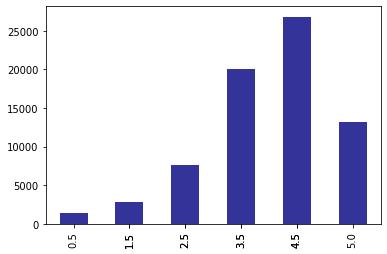

In [59]:
data['rating'].value_counts().plot(kind='bar',colormap='terrain')

To get more accurate results, we will only use movies and users which have been rated more than 20 times

In [60]:
filtered_movies = data['movieId'].value_counts() > 20
filtered_movies = filtered_movies[filtered_movies].index.tolist()


In [61]:
filtered_users = data['userId'].value_counts() > 20
filtered_users = filtered_users[filtered_users].index.tolist()


Now we have filtered users and movies as a list, and we will only use those values on our dataframe

In [62]:
data = data[(data['movieId'].isin(filtered_movies))&(data['userId'].isin(filtered_users))]

In [63]:
data

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100803,610,148626,4.0
100808,610,152081,4.0
100829,610,164179,5.0
100830,610,166528,4.0


Now we do not have duplicate data and our data contains 66,405 rows (34,431 rows are removed).

In [64]:
data.shape

(66405, 3)

The Reader class is used to parse a file containing ratings.

In [65]:
reader = Reader(rating_scale =(0.5,5))

First create dataset from dataframe. Then create train and test set.

In [66]:
columns = ['userId','movieId','rating']

dataset = Dataset.load_from_df(data[columns],reader)

In [67]:
trainset = dataset.build_full_trainset()

testset = trainset.build_anti_testset()

Use SVD method

In [68]:
model = SVD(n_epochs = 25, verbose = True)

In [69]:
cross_validate(model, dataset, measures=['RMSE','MAE'], cv= 5, verbose= True)
print('Training Done')

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
P

Now we can predict

In [70]:
prediction = model.test(testset)

In [71]:
prediction[1]

Prediction(uid=1, iid=1704, r_ui=3.6276635795497327, est=4.8336483265246155, details={'was_impossible': False})

We will define a function to recommend movies based on prediction for each user.

In [72]:
def get_Recommendations(prediction, n):
    
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in prediction:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_Recommendations(prediction, n=5)
for uid, user_ratings in top_n.items():
    movie_id = []
    print("Recommendations for User {}:".format(uid))
    for (iid, ratings) in user_ratings:
        print("\t", movies[movies.movieId==iid]["title"].values[0])
    print("\n")

Recommendations for User 1:
	 Shawshank Redemption, The (1994)
	 Dark Knight, The (2008)
	 Patton (1970)
	 Requiem for a Dream (2000)
	 Rear Window (1954)


Recommendations for User 2:
	 Philadelphia Story, The (1940)
	 Boondock Saints, The (2000)
	 Lock, Stock & Two Smoking Barrels (1998)
	 Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
	 Terminator, The (1984)


Recommendations for User 3:
	 Taxi Driver (1976)
	 Philadelphia Story, The (1940)
	 Maltese Falcon, The (1941)
	 Dark Knight, The (2008)
	 Green Mile, The (1999)


Recommendations for User 4:
	 Apocalypse Now (1979)
	 Boondock Saints, The (2000)
	 Blazing Saddles (1974)
	 Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
	 Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)


Recommendations for User 5:
	 Godfather, The (1972)
	 Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
	 Fight Club (1999)
	 Lawrence of Arabia (1962)
	 Patton (1970)


Re

# Content Based With Another Dataset

MovieLens dataset was a big dataset and we could not train it on our device with IDE like PyCharm. We were out of memory and to develop a GUI we decided to find another small dataset with more attributes which represents movies better. 

#### Libraries

In [73]:
from sklearn.feature_extraction.text import CountVectorizer

#### Read Dataset

In [74]:
movie_data = pd.read_csv("movie_data.csv")

In [75]:
movie_data.head()

,director_name,duration,actor_2_name,genres,actor_1_name,movie_title,num_voted_users,actor_3_name,movie_imdb_link,num_user_for_reviews,language,country,title_year,imdb_score,movie_id
0,James Cameron,178.0,Joel David Moore,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,Wes Studi,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054,English,USA,2009,7.9,1
1,Gore Verbinski,169.0,Orlando Bloom,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,Jack Davenport,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238,English,USA,2007,7.1,2
2,Sam Mendes,148.0,Rory Kinnear,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,Stephanie Sigman,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994,English,UK,2015,6.8,3
3,Christopher Nolan,164.0,Christian Bale,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,Joseph Gordon-Levitt,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701,English,USA,2012,8.5,4
4,Doug Walker,NaN,Rob Walker,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens,8,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,7.1,5


This dataset has 5043 movies

#### Preprocessing

We will use actor names, director name and genre to define the similarity.

In [76]:
columns = ["actor_1_name","actor_2_name","director_name","genres","movie_title"]

In [77]:
movie_data[columns].head()

,actor_1_name,actor_2_name,director_name,genres,movie_title
0,CCH Pounder,Joel David Moore,James Cameron,Action|Adventure|Fantasy|Sci-Fi,Avatar
1,Johnny Depp,Orlando Bloom,Gore Verbinski,Action|Adventure|Fantasy,Pirates of the Caribbean: At World's End
2,Christoph Waltz,Rory Kinnear,Sam Mendes,Action|Adventure|Thriller,Spectre
3,Tom Hardy,Christian Bale,Christopher Nolan,Action|Thriller,The Dark Knight Rises
4,Doug Walker,Rob Walker,Doug Walker,Documentary,Star Wars: Episode VII - The Force Awakens


In [78]:
# Check for any missing values in the important columns
movie_data[columns].isnull().values.any()

False

In [79]:
# Function to create a value to combine the values of the important columns into a single string
def get_important_features(data):
    important_features = []
    for i in range(0,data.shape[0]):
        lis = [str(data['movie_title'][i]), str(data["actor_1_name"][i]), str(data['actor_2_name'][i]),str(data['director_name'][i]),str(data['genres'][i])]
        x = ' '.join(lis)

        important_features.append(x)

    return important_features

We added a column to store important features.

In [80]:
movie_data["important_features"] = get_important_features(movie_data)

In [81]:
movie_data.head()

,director_name,duration,actor_2_name,genres,actor_1_name,movie_title,num_voted_users,actor_3_name,movie_imdb_link,num_user_for_reviews,language,country,title_year,imdb_score,movie_id,important_features
0,James Cameron,178.0,Joel David Moore,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,Wes Studi,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054,English,USA,2009,7.9,1,Avatar CCH Pounder Joel David Moore James Came...
1,Gore Verbinski,169.0,Orlando Bloom,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,Jack Davenport,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238,English,USA,2007,7.1,2,Pirates of the Caribbean: At World's End Johnn...
2,Sam Mendes,148.0,Rory Kinnear,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,Stephanie Sigman,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994,English,UK,2015,6.8,3,Spectre Christoph Waltz Rory Kinnear Sam Mend...
3,Christopher Nolan,164.0,Christian Bale,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,Joseph Gordon-Levitt,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701,English,USA,2012,8.5,4,The Dark Knight Rises Tom Hardy Christian Bale...
4,Doug Walker,NaN,Rob Walker,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens,8,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,7.1,5,Star Wars: Episode VII - The Force Awakens Dou...


In [82]:
# Convert the text to a matrix of token counts
count_matrix = CountVectorizer().fit_transform(movie_data["important_features"])

In [83]:
# Get the cosine similarity matrix from the count matrix
cosine_similar = cosine_similarity(count_matrix)

In [84]:
print(cosine_similar)

[[1.         0.20801257 0.1754116  ... 0.         0.         0.        ]
 [0.20801257 1.         0.15811388 ... 0.         0.         0.        ]
 [0.1754116  0.15811388 1.         ... 0.09128709 0.         0.        ]
 ...
 [0.         0.         0.09128709 ... 1.         0.08006408 0.        ]
 [0.         0.         0.         ... 0.08006408 1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [85]:
cosine_similar.shape

(5043, 5043)

In [86]:
title = input("Select a movie to get recommendations:")

Select a movie to get recommendations:iron man 3


Function to find index of the movie entered by the user

In [87]:
def recommender(movie_name):

    index = process.extractOne(title, movie_data["movie_title"])[0]

    return index

title  = recommender(title)

In [88]:
movie_id = movie_data[movie_data.movie_title == title]["movie_id"].values[0]

In [89]:
# Create a list of enumerations for the similarity score
scores = list(enumerate(cosine_similar[movie_id]))

In [90]:
# Sort the  list to get most similar ones
sorted_scores = sorted(scores,key = lambda x:x[1], reverse = True)
sorted_scores = sorted_scores[1:]

In [91]:
print(sorted_scores)

[(4128, 1.0000000000000002), (106, 0.6172133998483678), (118, 0.521749194749951), (1642, 0.4629100498862758), (2177, 0.4564354645876385), (134, 0.4166666666666668), (9, 0.35007002100700246), (602, 0.3481553119113957), (2449, 0.3481553119113957), (181, 0.3333333333333334), (708, 0.3333333333333334), (262, 0.3202563076101743), (593, 0.3202563076101743), (2332, 0.314970394174356), (38, 0.3086066999241839), (188, 0.3086066999241839), (945, 0.3086066999241839), (3010, 0.3086066999241839), (4752, 0.3086066999241839), (4778, 0.3086066999241839), (191, 0.29814239699997197), (1976, 0.29814239699997197), (2389, 0.29814239699997197), (1, 0.2886751345948129), (13, 0.2886751345948129), (18, 0.2886751345948129), (19, 0.2886751345948129), (500, 0.2886751345948129), (1119, 0.2886751345948129), (2036, 0.2886751345948129), (1400, 0.28867513459481287), (1863, 0.28867513459481287), (2623, 0.28867513459481287), (273, 0.280056016805602), (2512, 0.280056016805602), (145, 0.27386127875258315), (303, 0.2738612

In [92]:
# Print the first 10 similar movies
j = 0
print('The most recommended movies to',title,'are:\n')

for item in sorted_scores:
    movie_title = movie_data[movie_data.movie_id == item[0]]["movie_title"].values[0]
    print(j+1 ,movie_title)
    j = j+1
    if j >9:
        break

The most recommended movies to Iron Man 3 are:

1 My Big Fat Independent Movie
2 Poseidon
3 I Am Legend
4 The Three Stooges
5 Why Did I Get Married Too?
6 Wrath of the Titans
7 Avengers: Age of Ultron
8 Battle Los Angeles
9 The Last Station
10 Turbo
